In [13]:
import networkx as nx
import pandas as pd

In [14]:
df = pd.read_csv('../network/ia-escorts-dynamic.edges', sep=' ', skiprows=2, names= ["BuyerID", "SellerID", "Review", "Time"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50632 entries, 0 to 50631
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   BuyerID   50632 non-null  int64
 1   SellerID  50632 non-null  int64
 2   Review    50632 non-null  int64
 3   Time      50632 non-null  int64
dtypes: int64(4)
memory usage: 1.5 MB


In [15]:
from datetime import datetime

df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x))
df['Time'][:10]

0   2002-08-31 23:00:00
1   2002-08-31 23:00:00
2   2002-08-31 23:00:00
3   2002-09-21 23:00:00
4   2002-10-17 23:00:00
5   2002-11-12 22:00:00
6   2002-12-14 22:00:00
7   2002-12-30 22:00:00
8   2003-01-02 22:00:00
9   2003-01-04 22:00:00
Name: Time, dtype: datetime64[ns]

In [16]:
df['Time'].apply(lambda x: x.strftime('%H:%M:%S')).unique()

array(['23:00:00', '22:00:00'], dtype=object)

In [18]:
print('min: ' + df['Time'].min().strftime('%d/%m/%Y'))
print('max: ' + df['Time'].max().strftime('%d/%m/%Y'))

min: 31/08/2002
max: 10/10/2008


In [123]:
from datetime import timedelta

net = nx.MultiGraph(name="Companion Network")

n_top_n = 8

# month keyed dicts
n_nodes_dict = dict()
n_buyers_dict = dict()
n_sellers_dict = dict()

top_sellers_nodes_dict = dict()
top_buyers_nodes_dict = dict()

top_n_stop = datetime.strptime('01/01/2003', '%d/%m/%Y')
n_nodes_stop = datetime.strptime('01/01/2003', '%d/%m/%Y')
for _, row in df.iterrows():
    if row['Time'] >= n_nodes_stop:
        n_nodes_dict[n_nodes_stop - timedelta(days=1)] = len(net.nodes())
        n_buyers_dict[n_nodes_stop - timedelta(days=1)] = len([n for n in net.nodes() if n.startswith('b')])
        n_sellers_dict[n_nodes_stop - timedelta(days=1)] = len([n for n in net.nodes() if n.startswith('s')])
        
        if n_nodes_stop.month == 12:
            n_nodes_stop = datetime(year=n_nodes_stop.year+1, month=1, day=1)
        else:
            n_nodes_stop = datetime(year=n_nodes_stop.year, month=n_nodes_stop.month+1, day=1)
    
    if row['Time'] >= top_n_stop:
        buyers = [n for n in net.nodes() if n.startswith('b')]
        top_buyers_nodes_dict[top_n_stop - timedelta(days=1)] = sorted([(n, net.degree(n)) for n in buyers], key=lambda x: x[1], reverse=True)[:n_top_n]

        sellers = [n for n in net.nodes() if n.startswith('s')]
        top_sellers_nodes_dict[top_n_stop - timedelta(days=1)] = sorted([(n, net.degree(n)) for n in sellers], key=lambda x: x[1], reverse=True)[:n_top_n]
        
        if top_n_stop.month != 1:
            top_n_stop = datetime(year=top_n_stop.year+1, month=1, day=1)
        else:
            top_n_stop = datetime(year=top_n_stop.year, month=top_n_stop.month+6, day=1)
    
    net.add_edge("b"+str(row["BuyerID"]), "s"+str(row["SellerID"]), review=row['Review'], time=row['Time'])    
    
n_nodes_dict[row['Time'] - timedelta(days=1)] = len(net.nodes())
n_buyers_dict[row['Time'] - timedelta(days=1)] = len([n for n in net.nodes() if n.startswith('b')])
n_sellers_dict[row['Time'] - timedelta(days=1)] = len([n for n in net.nodes() if n.startswith('s')])
        
buyers = [n for n in net.nodes() if n.startswith('b')]
top_buyers_nodes_dict[top_n_stop - timedelta(days=1)] = sorted([(n, net.degree(n)) for n in buyers], key=lambda x: x[1], reverse=True)[:n_top_n]        
        
sellers = [n for n in net.nodes() if n.startswith('s')]
top_sellers_nodes_dict[row['Time'] - timedelta(days=1)] = sorted([(n, net.degree(n)) for n in sellers], key=lambda x: x[1], reverse=True)[:n_top_n]
        

In [ ]:
import matplotlib.pyplot as plt

x1 = list(n_nodes_dict.keys())
x2 = [v for _, v in n_nodes_dict.items()]
plt.plot(x1, x2, label='buyers and sellers')

x1 = list(n_buyers_dict.keys())
x2 = [v for _, v in n_buyers_dict.items()]
plt.plot(x1, x2, label='buyers')

x1 = list(n_sellers_dict.keys())
x2 = [v for _, v in n_sellers_dict.items()]
plt.plot(x1, x2, label='sellers')

plt.title('Amount of nodes in the network over time')
plt.xlabel('Date')
plt.ylabel('# of nodes')
plt.legend()

plt.tight_layout()
plt.savefig('../plots/n_nodes_over_time.png')
plt.show()

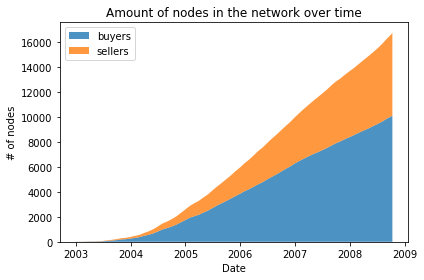

In [122]:
dates = n_buyers_dict.keys()

n_by_type = dict()
n_by_type['buyers'] = [v for _, v in n_buyers_dict.items()]
n_by_type['sellers'] = [v for _, v in n_sellers_dict.items()]

fig, ax = plt.subplots()
ax.stackplot(dates, n_by_type.values(),
             labels=n_by_type.keys(), alpha=0.8)
ax.set_title('Amount of nodes in the network over time')
ax.set_xlabel('Date')
ax.set_ylabel('# of nodes')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('../plots/stacked_n_nodes_over_time.png')
plt.show()

In [127]:
buyers = []
for _, v in list(top_buyers_nodes_dict.items())[1:]:
    buyers.extend([x[0] for x in v])
print(len(set(buyers)))

37


In [135]:
#palette = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']
def plot_top_types(top_dict, type):
    palette = [
        '#6929c4', '#1192e8', '#005d5d', '#9f1853',
        '#fa4d56', '#570408', '#198038', '#002d9c',
        '#ee538b', '#b28600', '#009d9a', '#012749',
        '#8a3800', '#a56eff'
    ]
    codes = []
    for _, v in list(top_dict.items())[1:]:
        codes.extend([x[0] for x in v])
    codes = set(codes)
    color_dict = dict()
    for i, c in enumerate(codes):
        color_dict[c] = palette[i % len(palette)]

    fig, axs = plt.subplots(6, 2, figsize=(10, 11), sharex=True)
    fig.suptitle(f'Top {type}s from June 2003 to October 2008', fontsize=16)

    for (key, top_s), ax in zip(list(top_dict.items())[1:], axs.flat):
        plt.sca(ax)
        ax.set_title(key.strftime('%b %Y'))
        
        x1, x2 = zip(*sorted(top_s, key=lambda x: x[1]))
        plt.barh(x1, x2, color=[color_dict[s] for s in x1])
        
    for ax in axs.flat[::-1][:2]:
        ax.set_xlabel('# of reviews')
        
    for i in range(0, 12, 2):
        axs.flat[i].set_ylabel(f'{type} code')
        
    plt.tight_layout()
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.savefig(f'../plots/best_{type}s.png')
    plt.show()

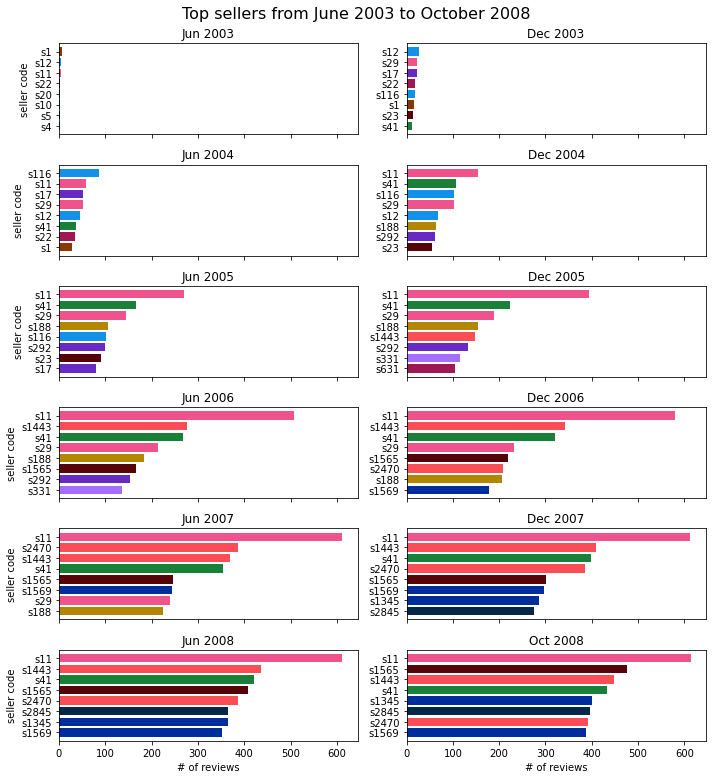

In [136]:
plot_top_types(top_sellers_nodes_dict, 'seller')

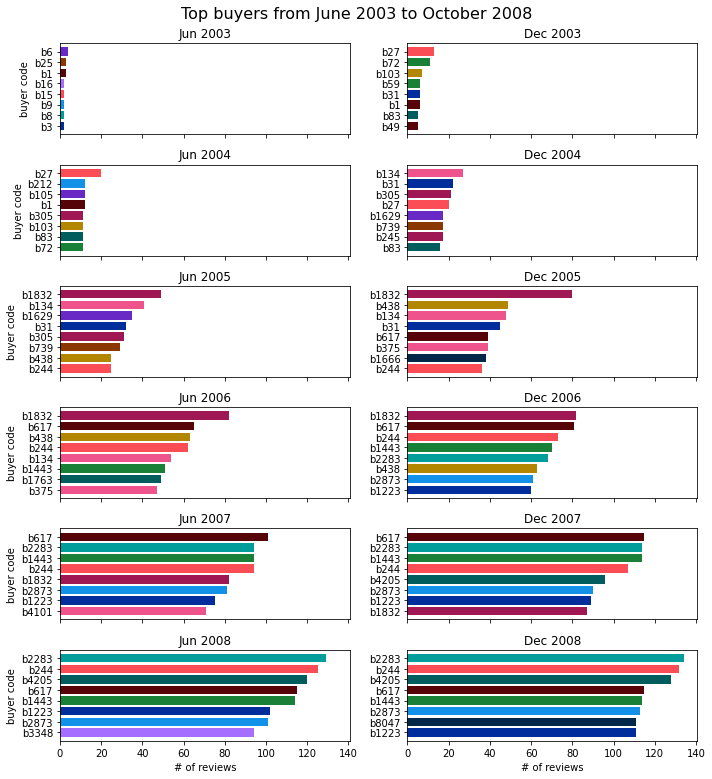

In [137]:
plot_top_types(top_buyers_nodes_dict, 'buyer')